In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "HSF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn029931,MYIYDGTQFPIKHEEYLKLDHDEREEVIEAWYMDDSHEDQRLPHHR...,518,1
1,Achn057551,MNKSHKAVPAPFLTKTYQLVDDPSSDHIVSWGEDDTTFVVWRPQEF...,310,1
2,Achn081581,MEGLLKRIMRFMNHIELTIEHQGETRINDDGSLSPARGRFEDSTVD...,343,1
3,Achn086291,MSPDDKPPFSHSKSPSYSSCLPGSEPESSIIPPASSSSAQFKSGFS...,512,1
4,Achn091321,MGQRSVPAPFLMKTYKLVDDQSTDEVIGWNEGGTTFVVWKTDNFSK...,481,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
768,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.029851,0.007463,...,0.00000,0.0000,0.007463,0.0,0.00000,0.0,0.007463,0.0,0.0,0.00000
884,0.000000,0.0,0.000000,0.006849,0.006849,0.000000,0.000000,0.00000,0.006849,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
431,0.010941,0.0,0.017505,0.004376,0.002188,0.000000,0.002188,0.00000,0.002188,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
2725,0.033223,0.0,0.003322,0.003322,0.003322,0.003322,0.000000,0.00000,0.000000,0.000000,...,0.00000,0.0000,0.000000,0.0,0.00000,0.0,0.000000,0.0,0.0,0.00000
7947,0.005900,0.0,0.000000,0.008850,0.000000,0.000000,0.005900,0.00295,0.000000,0.014749,...,0.00295,0.0059,0.000000,0.0,0.00295,0.0,0.002950,0.0,0.0,0.00295


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7295, 441)
X_test: (1824, 441)
y_train: (7295,)
y_test: (1824,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 42s 466ms/step - accuracy: 0.4688 - loss: 0.6931

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6787 - loss: 0.6821   

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.6246

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8114 - loss: 0.5458

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8125 - loss: 0.5436 - val_accuracy: 0.9781 - val_loss: 0.0646


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0664

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9802 - loss: 0.0656

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0587

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9837 - loss: 0.0544

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9839 - loss: 0.0539 - val_accuracy: 0.9863 - val_loss: 0.0349


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0047

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0158

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0210

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0251

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0256 - val_accuracy: 0.9863 - val_loss: 0.0426


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0252

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0215

56/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0213

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0207

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0207 - val_accuracy: 0.9883 - val_loss: 0.0339


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0159

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0160

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0156

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0157 - val_accuracy: 0.9870 - val_loss: 0.0428


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0118

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0134

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0146

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0147 - val_accuracy: 0.9863 - val_loss: 0.0416


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0026

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0100

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0107

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0116

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0117 - val_accuracy: 0.9822 - val_loss: 0.0635


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0332

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0187

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0159

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0147

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0146 - val_accuracy: 0.9870 - val_loss: 0.0462


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0034

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0051

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0072

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0075 - val_accuracy: 0.9856 - val_loss: 0.0540


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0015

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0122

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0103

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0130

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9952 - loss: 0.0136 - val_accuracy: 0.9781 - val_loss: 0.0741


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0069

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9900 - loss: 0.0321

57/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9889 - loss: 0.0362

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0352

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9894 - loss: 0.0346 - val_accuracy: 0.9842 - val_loss: 0.0547


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0030

31/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0020

59/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0042

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0054

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0056 - val_accuracy: 0.9808 - val_loss: 0.0737


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0042

29/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0087

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0089

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0092

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0094 - val_accuracy: 0.9808 - val_loss: 0.0714


Epoch 14/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.0038

30/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0301

58/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0258

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0221

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0216 - val_accuracy: 0.9726 - val_loss: 0.1191



[Train Accuracy: 99.61% - Test Accuracy: 97.20%]


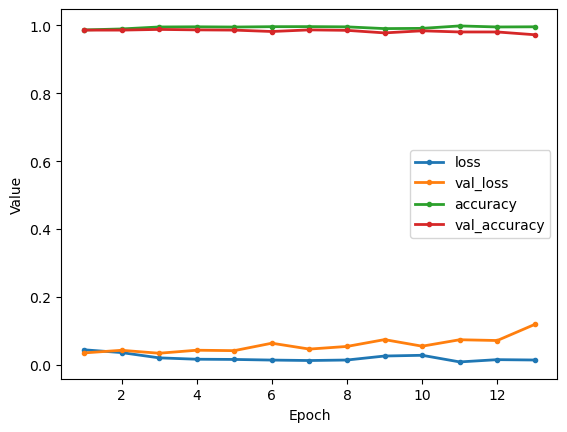

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 410us/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
768,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.004386,0.0,0.0,0.002193,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.016667,0.0,0.0,0.003333,0.0,0.003333,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7947,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.002959,0.0,0.0,0.002959,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (7295, 8905)
X_test: (1824, 8905)
y_train: (7295,)
y_test: (1824,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,279,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,323,201 (8.86 MB)

 Trainable params: 2,323,201 (8.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 45s 496ms/step - accuracy: 0.6094 - loss: 0.6931

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5629 - loss: 0.6927   

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6147 - loss: 0.6912

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6646 - loss: 0.6875

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7040 - loss: 0.6797

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7345 - loss: 0.6657

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7587 - loss: 0.6450

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7764 - loss: 0.6231

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7931 - loss: 0.5973

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8071 - loss: 0.5722

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8179 - loss: 0.5509

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8251 - loss: 0.5358 - val_accuracy: 0.9952 - val_loss: 0.0138


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 0.0083

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0080 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0094

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0095

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9985 - loss: 0.0099

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0101

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0101

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0101

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0100

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9982 - loss: 0.0100

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9981 - loss: 0.0099

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9981 - loss: 0.0099 - val_accuracy: 0.9952 - val_loss: 0.0158


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.7941e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014     

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0015

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0014

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9966 - val_loss: 0.0133


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.4607e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.1752e-04 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9467e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.5354e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4499e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3163e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.1430e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9545e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7584e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5692e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3938e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.3394e-04 - val_accuracy: 0.9952 - val_loss: 0.0164


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.8011e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4772e-04 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7318e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8771e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0439e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2916e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4170e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5204e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6125e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6758e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7071e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.7145e-04 - val_accuracy: 0.9952 - val_loss: 0.0172


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 2.8120e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3610e-04 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1217e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0772e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0766e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0601e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0364e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0355e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0326e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0271e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0210e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.0159e-04 - val_accuracy: 0.9952 - val_loss: 0.0169


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 1.4395e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1614e-04 

17/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0606e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0703e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0549e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0290e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0276e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0353e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0764e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1227e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1520e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 1.1706e-04 - val_accuracy: 0.9966 - val_loss: 0.0159


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 3.3598e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5766e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.2873e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4643e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5326e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6996e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9021e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9772e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9957e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9902e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9597e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 5.9529e-05 - val_accuracy: 0.9952 - val_loss: 0.0193


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 6.3259e-06

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5295e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5586e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8172e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9392e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9792e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9873e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9791e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0114e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0330e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0360e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 4.0463e-05 - val_accuracy: 0.9952 - val_loss: 0.0189


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 5.8417e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.0002e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.5738e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.3485e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1880e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0256e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8725e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7591e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6652e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5909e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5921e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 3.5941e-05 - val_accuracy: 0.9952 - val_loss: 0.0176


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.4621e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4942e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5906e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6348e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7003e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7570e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8022e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8262e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8715e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8834e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8906e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8874e-05 - val_accuracy: 0.9952 - val_loss: 0.0205


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 6.4764e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.1225e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9408e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8064e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7795e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7605e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7176e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6801e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6478e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6212e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5873e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.5659e-05 - val_accuracy: 0.9952 - val_loss: 0.0200


Epoch 13/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.5154e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.5556e-05 

18/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4672e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3357e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4782e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7398e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8511e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8847e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8955e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8921e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8859e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 1.0000 - loss: 2.8813e-05 - val_accuracy: 0.9952 - val_loss: 0.0186



[Train Accuracy: 100.00% - Test Accuracy: 99.62%]


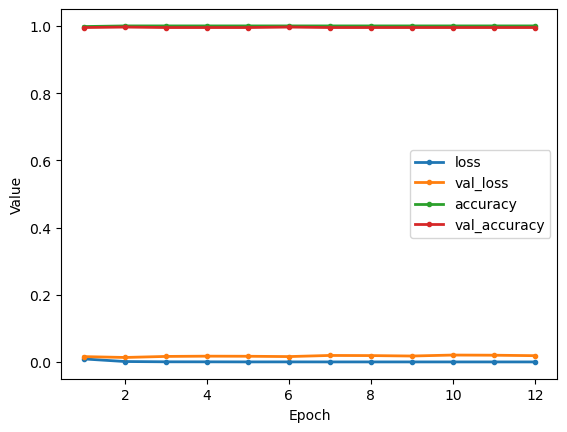

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
768,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431,0.002198,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2725,0.003344,0.0,0.0,0.003344,0.0,0.003344,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7947,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,727,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,768,641 (147.89 MB)

 Trainable params: 38,768,641 (147.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 1:01 673ms/step - accuracy: 0.5938 - loss: 0.6931

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - accuracy: 0.5703 - loss: 0.6931 

 3/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5486 - loss: 0.6931 

 4/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5423 - loss: 0.6931

 5/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.5457 - loss: 0.6931

 6/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.5455 - loss: 0.6930

 7/92 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.5466 - loss: 0.6929

 8/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5479 - loss: 0.6928

 9/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5482 - loss: 0.6928

10/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5469 - loss: 0.6927

11/92 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.5464 - loss: 0.6926

12/92 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5478 - loss: 0.6925

13/92 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.5508 - loss: 0.6924

14/92 ━━━━━━━━━━━━━━━━━━━━ 8s 113ms/step - accuracy: 0.5553 - loss: 0.6923

15/92 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5606 - loss: 0.6921

16/92 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5664 - loss: 0.6920

17/92 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5726 - loss: 0.6918

18/92 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5788 - loss: 0.6916

19/92 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5850 - loss: 0.6914

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.5911 - loss: 0.6911

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.5969 - loss: 0.6909

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.6026 - loss: 0.6906

23/92 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.6083 - loss: 0.6903

24/92 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.6140 - loss: 0.6900

25/92 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6195 - loss: 0.6896

26/92 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6249 - loss: 0.6892

27/92 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6301 - loss: 0.6888

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.6353 - loss: 0.6884

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6403 - loss: 0.6879

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6452 - loss: 0.6873

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 0.6500 - loss: 0.6867

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.6546 - loss: 0.6861

33/92 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6591 - loss: 0.6854

34/92 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 0.6634 - loss: 0.6846

35/92 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.6676 - loss: 0.6839

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.6717 - loss: 0.6830

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.6757 - loss: 0.6821

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6796 - loss: 0.6812

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6835 - loss: 0.6802

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 0.6872 - loss: 0.6791

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6908 - loss: 0.6779

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.6943 - loss: 0.6767

43/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.6977 - loss: 0.6754

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7010 - loss: 0.6740

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7042 - loss: 0.6726

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7073 - loss: 0.6711

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7104 - loss: 0.6695

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7133 - loss: 0.6678

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7163 - loss: 0.6661

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.7191 - loss: 0.6643

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.7219 - loss: 0.6624

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7246 - loss: 0.6605

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7273 - loss: 0.6585

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7299 - loss: 0.6564

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7325 - loss: 0.6543

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7350 - loss: 0.6521

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7375 - loss: 0.6498

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7399 - loss: 0.6475

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.7422 - loss: 0.6452

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7445 - loss: 0.6428

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7468 - loss: 0.6404

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7490 - loss: 0.6380

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7511 - loss: 0.6355

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7533 - loss: 0.6330

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7553 - loss: 0.6305

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7574 - loss: 0.6280

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.7594 - loss: 0.6254

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7614 - loss: 0.6229

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7633 - loss: 0.6203

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7652 - loss: 0.6177

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7670 - loss: 0.6151

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.7689 - loss: 0.6125

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7707 - loss: 0.6099

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7724 - loss: 0.6073

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.7742 - loss: 0.6047

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7759 - loss: 0.6021

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7776 - loss: 0.5995

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7792 - loss: 0.5969

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7808 - loss: 0.5944

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7824 - loss: 0.5918

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7840 - loss: 0.5892

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7855 - loss: 0.5867

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.7870 - loss: 0.5841

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7885 - loss: 0.5816

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7900 - loss: 0.5791

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7914 - loss: 0.5766

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7928 - loss: 0.5741

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7942 - loss: 0.5716

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7956 - loss: 0.5692

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7970 - loss: 0.5667

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7983 - loss: 0.5643

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.7996 - loss: 0.5619

92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 178ms/step - accuracy: 0.8009 - loss: 0.5595 - val_accuracy: 0.9918 - val_loss: 0.0223


Epoch 2/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.9688 - loss: 0.0410

 2/92 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - accuracy: 0.9766 - loss: 0.0321

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - accuracy: 0.9809 - loss: 0.0268

 4/92 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.9837 - loss: 0.0233

 5/92 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.9851 - loss: 0.0223

 6/92 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.9863 - loss: 0.0213

 7/92 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.9873 - loss: 0.0203

 8/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9881 - loss: 0.0194

 9/92 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.9889 - loss: 0.0186

10/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9895 - loss: 0.0179

11/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9901 - loss: 0.0172

12/92 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9906 - loss: 0.0166

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9910 - loss: 0.0161

14/92 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.9914 - loss: 0.0157

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - accuracy: 0.9918 - loss: 0.0153

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.9921 - loss: 0.0149

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.9924 - loss: 0.0145

18/92 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.9927 - loss: 0.0142

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9930 - loss: 0.0139 

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9932 - loss: 0.0136

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9934 - loss: 0.0133

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9935 - loss: 0.0131

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9937 - loss: 0.0129

24/92 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 0.9939 - loss: 0.0127

25/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.9940 - loss: 0.0125

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.9941 - loss: 0.0123

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9943 - loss: 0.0121

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9944 - loss: 0.0120

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9945 - loss: 0.0119

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9946 - loss: 0.0117

31/92 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.9947 - loss: 0.0116

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.9947 - loss: 0.0115

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9948 - loss: 0.0113

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9949 - loss: 0.0112

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9950 - loss: 0.0111

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9951 - loss: 0.0110

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9951 - loss: 0.0109

38/92 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.9952 - loss: 0.0108

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9953 - loss: 0.0107

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9953 - loss: 0.0106

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0105

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9954 - loss: 0.0104

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9955 - loss: 0.0103

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9956 - loss: 0.0102

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9956 - loss: 0.0101

46/92 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 0.9957 - loss: 0.0101

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9957 - loss: 0.0100

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9958 - loss: 0.0099

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9958 - loss: 0.0098

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9958 - loss: 0.0097

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9959 - loss: 0.0097

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.9959 - loss: 0.0096

53/92 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.9960 - loss: 0.0095

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9960 - loss: 0.0094

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9961 - loss: 0.0094

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9961 - loss: 0.0093

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9961 - loss: 0.0092

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.9962 - loss: 0.0092

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9962 - loss: 0.0091

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9963 - loss: 0.0090

61/92 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9963 - loss: 0.0090

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9963 - loss: 0.0089

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9964 - loss: 0.0088

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9964 - loss: 0.0088

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9964 - loss: 0.0087

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9965 - loss: 0.0087

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9965 - loss: 0.0086

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.9965 - loss: 0.0085

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9966 - loss: 0.0085

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9966 - loss: 0.0084

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9966 - loss: 0.0084

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9966 - loss: 0.0083

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9967 - loss: 0.0083

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9967 - loss: 0.0082

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9967 - loss: 0.0082

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 0.9967 - loss: 0.0081

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9968 - loss: 0.0081

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9968 - loss: 0.0081

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9968 - loss: 0.0080

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9968 - loss: 0.0080

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9969 - loss: 0.0079

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9969 - loss: 0.0079

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9969 - loss: 0.0079

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9969 - loss: 0.0078

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9969 - loss: 0.0078

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0078

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0077

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0077

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0077

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9970 - loss: 0.0076

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9971 - loss: 0.0076

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9971 - loss: 0.0076

92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 0.9971 - loss: 0.0075 - val_accuracy: 0.9979 - val_loss: 0.0086


Epoch 3/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 1.0000 - loss: 0.0012

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 0.0011

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 0.0011

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 9.9871e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.5203e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 9.2027e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.9382e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.7019e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 8.4810e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.2890e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.1134e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 7.9588e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 7.8196e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.6944e-04 

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.5948e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.5041e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.4176e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.3351e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.2514e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 7.1689e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.0918e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 1.0000 - loss: 7.0207e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.9544e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.8917e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.8468e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 6.8012e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7616e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 6.7493e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.7372e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.7222e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.7043e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.6845e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.6632e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.6653e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.6669e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 6.6669e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6707e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6712e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6691e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6648e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.6594e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.6524e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 1.0000 - loss: 6.6447e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 6.6363e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.6272e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.6178e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.6079e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.5972e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.5859e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.5746e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.5639e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.5533e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.5428e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.5318e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.5204e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.5096e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.4986e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.4883e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.4779e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4670e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4560e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4451e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4341e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4230e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4116e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.4004e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.3895e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3787e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3717e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.3643e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3567e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3487e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3404e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3320e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 6.3234e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.3146e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.3056e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2968e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2875e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2780e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2684e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2586e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 6.2488e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2389e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2287e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2185e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.2082e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1979e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1876e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1771e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 6.1668e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.1566e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 6.1466e-04 - val_accuracy: 0.9966 - val_loss: 0.0121


Epoch 4/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 1.0000 - loss: 3.0788e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 2.8873e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 11s 128ms/step - accuracy: 1.0000 - loss: 2.7595e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 2.6715e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 2.6010e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.6061e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5969e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 2.5959e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 129ms/step - accuracy: 1.0000 - loss: 2.6163e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.6249e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 2.6249e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 2.6311e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6328e-04 

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 2.6316e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6260e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6215e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6198e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6214e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6192e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 2.6157e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.6209e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.6289e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.6344e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.6378e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.6386e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.6372e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.6351e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.6338e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6325e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6315e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6328e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6340e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 2.6351e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.6355e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 2.6362e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6365e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.6385e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6401e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6409e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6409e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6407e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6402e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 2.6406e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6403e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6394e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6386e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6383e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6382e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6382e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6378e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.6372e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6368e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6359e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6345e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6331e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6315e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6300e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6283e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.6268e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6251e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6235e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6218e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6199e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6177e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6152e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6128e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 2.6103e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.6080e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.6059e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.6039e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 2.6018e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.5995e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.5971e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.5946e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 2.6009e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6068e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6125e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6180e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6232e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6282e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6333e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6382e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.6429e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6474e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6519e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6562e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6605e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6650e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6692e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6731e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 2.6769e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.6806e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 2.6842e-04 - val_accuracy: 0.9979 - val_loss: 0.0090


Epoch 5/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 25s 280ms/step - accuracy: 1.0000 - loss: 2.9367e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 2.6418e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 2.3912e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 2.3461e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 1.0000 - loss: 2.3586e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3506e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3369e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.3217e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3158e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3143e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.3169e-04

12/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.3121e-04 

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.3008e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2865e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2719e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2580e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 2.2469e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2380e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 124ms/step - accuracy: 1.0000 - loss: 2.2283e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 2.2204e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 2.2143e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 1.0000 - loss: 2.2074e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 2.1988e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 2.2031e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 2.2058e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.2071e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.2085e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.2090e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 2.2083e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.2075e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.2062e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.2038e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.2014e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 1.0000 - loss: 2.1986e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1956e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - accuracy: 1.0000 - loss: 2.1925e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1899e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1873e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1850e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1822e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1793e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1771e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1752e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 2.1728e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1700e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1691e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 2.1679e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1663e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1641e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1617e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1590e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 2.1563e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1534e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1502e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1469e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1434e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1398e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1361e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1322e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.1282e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.1242e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 2.1199e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1156e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1112e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1067e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.1024e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.0980e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 2.0936e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0892e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0847e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0803e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0758e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0713e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.0668e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.0623e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 2.0578e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.0532e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.0487e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.0442e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.0398e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.0352e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.0307e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.0276e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 2.0245e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0215e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0184e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0153e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0123e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0092e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0062e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0031e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.0000e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 1.9970e-04 - val_accuracy: 0.9966 - val_loss: 0.0129


Epoch 6/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 20s 222ms/step - accuracy: 1.0000 - loss: 6.4154e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 8.3628e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 9.2170e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 1.0000 - loss: 9.2970e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 1.0000 - loss: 9.3890e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 9.5596e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 9.8080e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 9.9925e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.0106e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.0158e-04

11/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.0192e-04 

12/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 1.0274e-04

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0365e-04

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0445e-04

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0523e-04

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0585e-04

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0636e-04

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 1.0667e-04

19/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0677e-04

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0683e-04

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0678e-04

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0662e-04

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0746e-04

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 1.0814e-04

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.0878e-04

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.0929e-04

27/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.0987e-04

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1043e-04

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1088e-04

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1127e-04

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1160e-04

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1191e-04

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1224e-04

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1256e-04

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 1.1288e-04

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1318e-04

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1343e-04

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1363e-04

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1377e-04

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1389e-04

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1396e-04

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1401e-04

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.1404e-04

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1404e-04

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1403e-04

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1400e-04

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1396e-04

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1391e-04

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1384e-04

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1375e-04

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.1367e-04

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1360e-04

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1351e-04

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1341e-04

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1371e-04

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1397e-04

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1422e-04

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1443e-04

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.1463e-04

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1487e-04

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1507e-04

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1525e-04

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1542e-04

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1557e-04

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1569e-04

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 1.1582e-04

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 1.1594e-04

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1605e-04

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1614e-04

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1621e-04

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1627e-04

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1632e-04

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1636e-04

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 1.1639e-04

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 1.1642e-04

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.1644e-04

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.1645e-04

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.1644e-04

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.1644e-04

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.1644e-04

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 1.1643e-04

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.1642e-04

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 1.1640e-04

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1639e-04

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1637e-04

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1635e-04

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1631e-04

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1628e-04

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1623e-04

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1619e-04

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 1.1616e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 1.1613e-04

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 130ms/step - accuracy: 1.0000 - loss: 1.1610e-04 - val_accuracy: 0.9966 - val_loss: 0.0127


Epoch 7/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 20s 224ms/step - accuracy: 1.0000 - loss: 9.3857e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 8.3932e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 8.5750e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 8.4551e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 8.5034e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 8.4647e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.4408e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.3923e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 8.3478e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.2851e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 8.2121e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 8.1852e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 1.0000 - loss: 8.1684e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 8.1398e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.1060e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 1.0000 - loss: 8.0665e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.0387e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 8.0121e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.9816e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.9517e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 7.9220e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.8945e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.8710e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.8451e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 7.8414e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.8348e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.8233e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.8089e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.7941e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.7780e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 7.7595e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.7409e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.7207e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.7003e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 7.6790e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 7.6605e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 7.6419e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.6224e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.6016e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.5807e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.5622e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.5439e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.5268e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.5094e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4926e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4756e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4613e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4462e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4408e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.4345e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.4280e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.4282e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.4314e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.4365e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.4410e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.4447e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.4486e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.4518e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 7.4538e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4546e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4545e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4546e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4544e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4548e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4548e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4561e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4565e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 7.4568e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4571e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4570e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4562e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4550e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4531e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4506e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4481e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 125ms/step - accuracy: 1.0000 - loss: 7.4450e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4423e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4393e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4363e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4329e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4289e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4245e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 1.0000 - loss: 7.4204e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.4160e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 7.4116e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.4068e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.4028e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.4009e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3992e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3976e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3957e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 7.3938e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 7.3919e-05 - val_accuracy: 0.9966 - val_loss: 0.0144


Epoch 8/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - accuracy: 1.0000 - loss: 1.8270e-04

 2/92 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - accuracy: 1.0000 - loss: 1.5727e-04

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 1.3949e-04

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 1.2778e-04

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 1.1985e-04

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 1.1370e-04

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.0868e-04

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 1.0434e-04

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 1.0124e-04

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.8694e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 9.6628e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 9.4858e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 9.3195e-05 

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 9.1525e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 9.0033e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 8.8566e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.7272e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.6226e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 8.5213e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 8.4275e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 8.3392e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 8.2527e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 8.1669e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 8.0923e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 8.0176e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 7.9508e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 7.8935e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 7.8505e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 7.8058e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 7.7621e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.7170e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.6730e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.6297e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 1.0000 - loss: 7.5860e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 7.5446e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.5038e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.4650e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.4263e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.4090e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 7.3904e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 7.3709e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 7.3502e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 7.3284e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 7.3068e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 7.2843e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 7.2625e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 7.2407e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.2185e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.1958e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.1733e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 7.1507e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.1287e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.1064e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0844e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0630e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0412e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0207e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 7.0018e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 6.9845e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9674e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9502e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9328e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9154e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8977e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8805e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8631e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.8462e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.8305e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.8153e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.7999e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.7861e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 6.7723e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.7631e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.7537e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 6.7440e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.7344e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.7249e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.7152e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.7052e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.6952e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.6849e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.6746e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 6.6640e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.6532e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.6427e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 6.6324e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.6222e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.6122e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.6020e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.5923e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.5827e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 6.5732e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 6.5639e-05 - val_accuracy: 0.9966 - val_loss: 0.0143


Epoch 9/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 1.0000 - loss: 3.4373e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 1.0000 - loss: 3.2420e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.2078e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.1867e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.3052e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.3928e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.4327e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.5703e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.6472e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.6967e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.7284e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7652e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.7799e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.7920e-05 

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.8197e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.8440e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.8619e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.8724e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 3.8763e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.8911e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.9090e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.9315e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.9512e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.9680e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.9806e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 3.9893e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.0021e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.0137e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.0236e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.0307e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.0407e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.0573e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 4.0727e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.0893e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.1081e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 4.1240e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1386e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1503e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1605e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1714e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1811e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1896e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.1969e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2032e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 4.2160e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2273e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2379e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2471e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2551e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2622e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 4.2684e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2733e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2785e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2829e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2863e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 4.2902e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2937e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.2974e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 4.3005e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.3034e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.3055e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 4.3069e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.3079e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.3084e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.3085e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.3086e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 4.3081e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3071e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3067e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3069e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3081e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3094e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3105e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3113e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 4.3118e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3118e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3119e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3114e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3159e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3198e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3232e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3261e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 1.0000 - loss: 4.3308e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3352e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3393e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3432e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3467e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3505e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3543e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 1.0000 - loss: 4.3580e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3615e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 1.0000 - loss: 4.3650e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step - accuracy: 1.0000 - loss: 4.3685e-05 - val_accuracy: 0.9966 - val_loss: 0.0145


Epoch 10/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 28s 317ms/step - accuracy: 1.0000 - loss: 2.0686e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 127ms/step - accuracy: 1.0000 - loss: 2.5668e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 2.7753e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.8281e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 2.8269e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.4407e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 1.0000 - loss: 3.7933e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 4.0156e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.1609e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.2549e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 4.4615e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 4.6197e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.7576e-05 

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 1.0000 - loss: 4.8604e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 4.9346e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 4.9932e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 1.0000 - loss: 5.0328e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 1.0000 - loss: 5.0579e-05 

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 1.0000 - loss: 5.0934e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 5.1176e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 5.1381e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 5.1534e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - accuracy: 1.0000 - loss: 5.1626e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 5.1665e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 1.0000 - loss: 5.1691e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 5.1702e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 5.1694e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 5.1676e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 1.0000 - loss: 5.1624e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 1.0000 - loss: 5.1549e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 5.1460e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 5.1359e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 1.0000 - loss: 5.1246e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.1115e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.0980e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.0836e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 1.0000 - loss: 5.0681e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.0541e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.0397e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.0247e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 5.0127e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 4.9998e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 4.9859e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 4.9728e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 4.9593e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9469e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9350e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9233e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9140e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.9039e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 4.8938e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 4.8832e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.8720e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8605e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8499e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8390e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8285e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 4.8177e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.8073e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 4.7968e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.7864e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.7757e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.7646e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 4.7534e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.7419e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.7309e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.7197e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 4.7084e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6972e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6856e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6740e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6627e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6520e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6414e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 4.6311e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 4.6210e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6108e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.6005e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 1.0000 - loss: 4.5902e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.5801e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.5700e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.5599e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.5499e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 4.5398e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.5299e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.5202e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.5105e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.5023e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.4943e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.4863e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 4.4783e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 4.4704e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 1.0000 - loss: 4.4628e-05 - val_accuracy: 0.9966 - val_loss: 0.0147


Epoch 11/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 28s 316ms/step - accuracy: 1.0000 - loss: 3.2498e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 1.0000 - loss: 3.0526e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 1.0000 - loss: 2.8442e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - accuracy: 1.0000 - loss: 2.8685e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - accuracy: 1.0000 - loss: 3.0183e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step - accuracy: 1.0000 - loss: 3.1689e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 1.0000 - loss: 3.2760e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 1.0000 - loss: 3.3236e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 3.3609e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 3.3998e-05 

11/92 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - accuracy: 1.0000 - loss: 3.4288e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4394e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4348e-05

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4232e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.4106e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 1.0000 - loss: 3.3994e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.3897e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 1.0000 - loss: 3.3780e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 3.3623e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 3.3511e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 3.3394e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 3.3248e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 122ms/step - accuracy: 1.0000 - loss: 3.3112e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.2970e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.2840e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 3.2708e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2615e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2527e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 1.0000 - loss: 3.2420e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.2309e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.2188e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.2060e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.1932e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 3.1806e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.1678e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.1552e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 3.1421e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.1294e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.1164e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.1041e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.0926e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.0826e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.0740e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0664e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0586e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0504e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0422e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.0336e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 3.0251e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0173e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 3.0099e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 3.0023e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9947e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9871e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9796e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9721e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.9649e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.9584e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 2.9516e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9450e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9386e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9325e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9264e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9204e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9142e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.9089e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.9038e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8985e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8931e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8877e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8822e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8766e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8710e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8654e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 2.8598e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.8545e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.8492e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.8439e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.8389e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 2.8341e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.8295e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.8251e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 2.8209e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.8167e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.8125e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.8088e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.8053e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.8017e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.7989e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.7963e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.7939e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 2.7916e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 1.0000 - loss: 2.7894e-05 - val_accuracy: 0.9966 - val_loss: 0.0153


Epoch 12/100


 1/92 ━━━━━━━━━━━━━━━━━━━━ 31s 351ms/step - accuracy: 1.0000 - loss: 1.5679e-05

 2/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 2.5330e-05

 3/92 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 1.0000 - loss: 2.8210e-05

 4/92 ━━━━━━━━━━━━━━━━━━━━ 11s 126ms/step - accuracy: 1.0000 - loss: 3.1375e-05

 5/92 ━━━━━━━━━━━━━━━━━━━━ 10s 124ms/step - accuracy: 1.0000 - loss: 3.2353e-05

 6/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.2266e-05

 7/92 ━━━━━━━━━━━━━━━━━━━━ 10s 125ms/step - accuracy: 1.0000 - loss: 3.2998e-05

 8/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.3257e-05

 9/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.3143e-05

10/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.3054e-05

11/92 ━━━━━━━━━━━━━━━━━━━━ 10s 126ms/step - accuracy: 1.0000 - loss: 3.2790e-05

12/92 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 1.0000 - loss: 3.2607e-05

13/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2554e-05 

14/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.2488e-05

15/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2373e-05

16/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2217e-05

17/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.2017e-05

18/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.1826e-05

19/92 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - accuracy: 1.0000 - loss: 3.1606e-05

20/92 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - accuracy: 1.0000 - loss: 3.1408e-05

21/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.1214e-05

22/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.1090e-05

23/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.1021e-05

24/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0982e-05

25/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0917e-05

26/92 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 3.0844e-05

27/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0769e-05

28/92 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 3.0697e-05

29/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0627e-05

30/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0579e-05

31/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0512e-05

32/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0432e-05

33/92 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 1.0000 - loss: 3.0351e-05

34/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0271e-05

35/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0186e-05

36/92 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 1.0000 - loss: 3.0092e-05

37/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9997e-05

38/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9900e-05

39/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9804e-05

40/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9703e-05

41/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9611e-05

42/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9524e-05

43/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9465e-05

44/92 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.9418e-05

45/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9364e-05

46/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9310e-05

47/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9252e-05

48/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.9188e-05

49/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9121e-05

50/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.9050e-05

51/92 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.8976e-05

52/92 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.8905e-05

53/92 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 2.8833e-05

54/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8774e-05

55/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8715e-05

56/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8662e-05

57/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8610e-05

58/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8557e-05

59/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8501e-05

60/92 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 2.8444e-05

61/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8386e-05

62/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8327e-05

63/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8265e-05

64/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8206e-05

65/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8149e-05

66/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8099e-05

67/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8051e-05

68/92 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 2.8000e-05

69/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7949e-05

70/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7899e-05

71/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7852e-05

72/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7805e-05

73/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7759e-05

74/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7714e-05

75/92 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 2.7670e-05

76/92 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 2.7624e-05

77/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7577e-05

78/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7529e-05

79/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7480e-05

80/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7430e-05

81/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7382e-05

82/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7390e-05

83/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7403e-05

84/92 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 1.0000 - loss: 2.7430e-05

85/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.7453e-05

86/92 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 1.0000 - loss: 2.7476e-05

87/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7496e-05

88/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7514e-05

89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7528e-05

90/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7540e-05

91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7549e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 1.0000 - loss: 2.7558e-05

92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 132ms/step - accuracy: 1.0000 - loss: 2.7566e-05 - val_accuracy: 0.9959 - val_loss: 0.0176



[Train Accuracy: 100.00% - Test Accuracy: 99.56%]


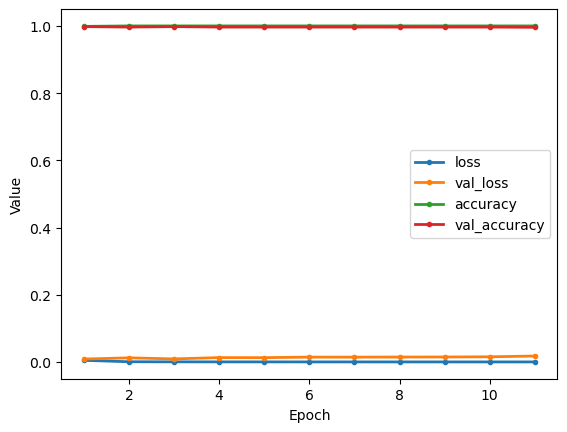

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/57 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step

 6/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

17/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

22/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

37/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

42/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

47/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

53/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


 1/57 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step

 6/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

11/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

26/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

38/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

43/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

49/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

55/57 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/HSF/report_ZAX2YJSV.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################